# Make Connection to Local SAS

In [1]:
### Local Connection to SAS ###
import saspy
sas=saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 9723



# Make Connection to CAS

In [2]:
### Connection to CAS ###
#import swat
#import os
#os.environ['CAS_CLIENT_SSL_CA_LIST']=r"c:\temp\trustedcerts.pem"
#conn=swat.CAS('https://URLtoCASTRESTYAPI:443/cas-shared-default-http/',username='USERNAME',password='PASSWORD')
#out=conn.serverstatus()
#print(out)

# Load Data & Get Some Information About Dataset

In [3]:
## Load Iris Data from CSV
#iris=sas.read_csv("./iris_classes1and2_scaled.csv", table="iris",libref="work")
iris=sas.read_csv("/home/u59725690/RawData/iris_classes1and2_scaled.csv", table="iris",libref="work")

In [4]:
## Load data from sashelp.class
#iris=sas.sasdata('iris','sashelp')

In [5]:
## Print Column Information
iris.columnInfo()

,Member,Num,Variable,Type,Len,Pos,Format,Informat
0,WORK.IRIS,3.0,PetalLength,Num,8.0,16.0,BEST12.,BEST32.
1,WORK.IRIS,4.0,PetalWidth,Num,8.0,24.0,BEST12.,BEST32.
2,WORK.IRIS,1.0,SepalLength,Num,8.0,0.0,BEST12.,BEST32.
3,WORK.IRIS,2.0,SepalWidth,Num,8.0,8.0,BEST12.,BEST32.
4,WORK.IRIS,5.0,Species,Num,8.0,32.0,BEST12.,BEST32.


In [6]:
## Print Out 1st couple of records
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,0.40,0.75,0.20,0.05,-1.0
1,0.30,0.50,0.20,0.05,-1.0
2,0.20,0.60,0.15,0.05,-1.0
3,0.15,0.55,0.25,0.05,-1.0
4,0.35,0.80,0.20,0.05,-1.0


In [7]:
#iris2 = sas.submit('''
#/****** Generate the Data *****/
#data work.iris (drop=species where=(spec_flag ne 3));
#    set sashelp.iris;
#    if species = 'Setosa' then spec_flag=1;
#    else if species='Versicolor' then spec_flag=2;
#    else spec_flag=3;
#run;
#''')


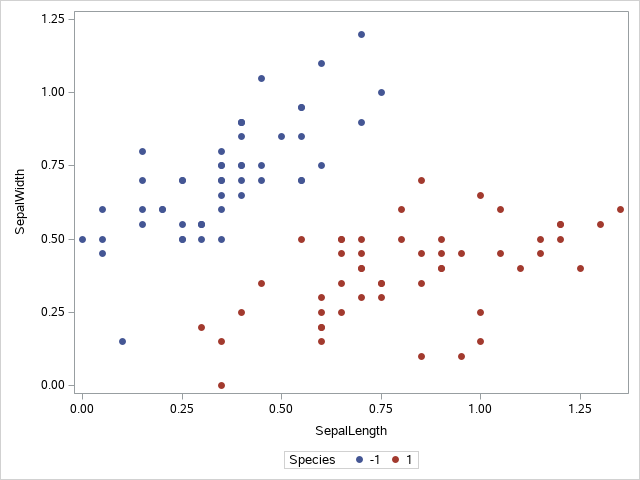

In [8]:
## Create scatterplot of SepalLength by SepalWidth Grouped by Species
code=sas.submitLST("""
proc sgplot data =  work.iris;
    	scatter x=SepalLength y= sepalwidth /  group=species 
                                               markerattrs=(symbol=circlefilled) ;
run;
""")


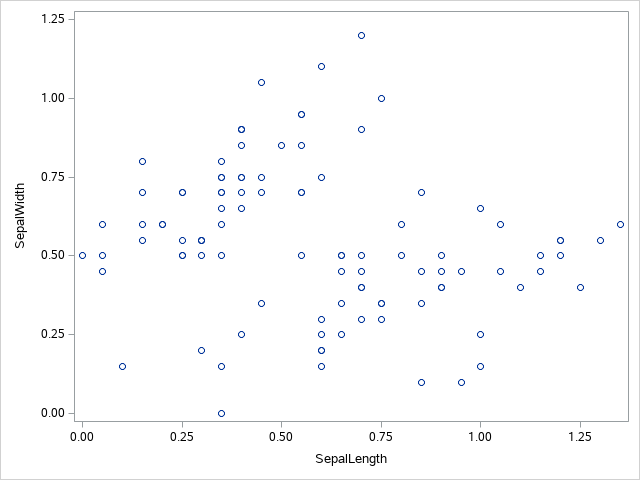

In [8]:
## Use SASPY method to plot SepalLength by SepalWidth
iris=sas.sasdata('iris','work')  
iris.scatter('SepalLength', 'sepalwidth')

In [9]:
## SASPY to run some descriptive Stats 
iris.means()

,Variable,N,NMiss,Median,Mean,StdDev,Min,P25,P50,P75,Max
0,SepalLength,100.0,0.0,0.550,0.5855,0.320849,0.0,0.35,0.550,0.800,1.35
1,SepalWidth,100.0,0.0,0.525,0.5470,0.238029,0.0,0.40,0.525,0.700,1.20
2,PetalLength,100.0,0.0,0.725,0.9310,0.724282,0.0,0.25,0.725,1.675,2.05
3,PetalWidth,100.0,0.0,0.350,0.3425,0.283144,0.0,0.05,0.350,0.600,0.85
4,Species,100.0,0.0,0.000,0.0000,1.005038,-1.0,-1.00,0.000,1.000,1.00


## Submit SAS Code to run Analysis
1. Unsupervised Clustering using SepalLength and SepalWidth
2. Relabel resulting clusters to match labels of Original Data and then create label if Incorrect Classification
3. Create some formats
4. Overalyed plots of SepalLength by SepalWidth grouped by species and cluster. Incorrect classifications are labeled on graph


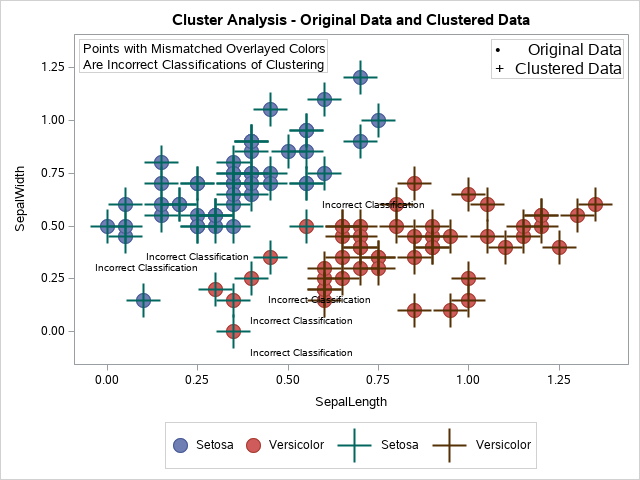

In [14]:
## Run Cluster Analysis in SAS - Perform Data Manpulation in SAS - Plot Data
code=sas.submitLST("""
proc fastclus data = work.iris maxc=2 maxiter=10 noprint out=clus;
	var sepallength sepalwidth;
run;

data clus;
	set clus;
	if cluster = 2 then cluster = -1;
		else cluster=1;
	if cluster ne species then decision='Incorrect Classification';
		else call missing(decision);
run;
proc format;
	value spec_fmt
	-1 = 'Setosa'
	1 = 'Versicolor'
;
run;

		
proc sgplot data = clus;
	scatter x=sepallength y=sepalwidth / 
			group=species
			filledoutlinedmarkers
			markerattrs=(symbol=circlefilled size=15) name='Original';
	scatter x=sepallength y=sepalwidth / 
			group=cluster
			markerattrs=(symbol=plus size=25 pt)
			name='Classified'
			datalabel=decision datalabelattrs=(color=Black);
	keylegend "Original" "Classified";
	inset  ("(*ESC*){unicode '2022'x}" = "Original Data"
		    "(*ESC*){unicode '002B'x}"= "Clustered Data") / 
				border position=topright textattrs=(color=black size=12); 
    inset "Points with Mismatched Overlayed Colors"
           "Are Incorrect Classifications of Clustering" / border position=topleft textattrs=(color=black size=10);
	format species cluster spec_fmt. ;
    title "Cluster Analysis - Original Data and Clustered Data";
run;
""")

# Get Data Ready for Quantum Analysis

In [15]:
# Convert SAS Pandas Dataframe 
df1 = iris.to_df()
print(df1)

    SepalLength  SepalWidth  PetalLength  PetalWidth  Species
0          0.40        0.75         0.20        0.05     -1.0
1          0.30        0.50         0.20        0.05     -1.0
2          0.20        0.60         0.15        0.05     -1.0
3          0.15        0.55         0.25        0.05     -1.0
4          0.35        0.80         0.20        0.05     -1.0
..          ...         ...          ...         ...      ...
95         0.70        0.50         1.60        0.55      1.0
96         0.70        0.45         1.60        0.60      1.0
97         0.95        0.45         1.65        0.60      1.0
98         0.40        0.25         1.00        0.50      1.0
99         0.70        0.40         1.55        0.60      1.0

[100 rows x 5 columns]


In [16]:
# Convert Pandas Dataframe to Numpy Array 
data = df1.to_numpy()
print("First 10 Data sample:", data[10])

First 10 Data sample: [ 0.55  0.85  0.25  0.05 -1.  ]


# XANADU - Penny Lane Quantum
1. Angle data encoding
2. Not Using built in embedding in case need to run on differ quantum hardware

In [17]:
import pennylane as qml
import strawberryfields as sf
from pennylane import numpy as np
import pandas as pd
#from pennylane.templates.embeddings import AngleEmbedding
from pennylane.optimize import NesterovMomentumOptimizer, AdagradOptimizer, GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer


In [18]:
# Define Quantum Device - The examples are local devices, can be changed to real quantum devices.
# Using a 2-Qubit Quantum Simulator. 
# Two Qubits were used, one for each variable
dev = qml.device("default.qubit", wires=2)                                            # XanaduPennyLane
#dev = qml.device("qiskit.aer", wires=2)                                              # IBM Local SDK - Runs Slow 


 Every input x has to be translated into a set of angles which can get fed into a small routine for state preparation. 

In [19]:
# Get angles for each input
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

# State Preparation pushing Data int Quantum States
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

## Test StatePreparation part of Circuit with Dummy Data

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  7.95036065e-01  2.78265032e-01 -2.77555756e-17]


0: ──RY(0.56)─╭●────────────╭●──X────────╭●────────────╭●──X────────┤  <Z>
1: ───────────╰X──RY(-0.00)─╰X──RY(0.00)─╰X──RY(-0.98)─╰X──RY(0.98)─┤     


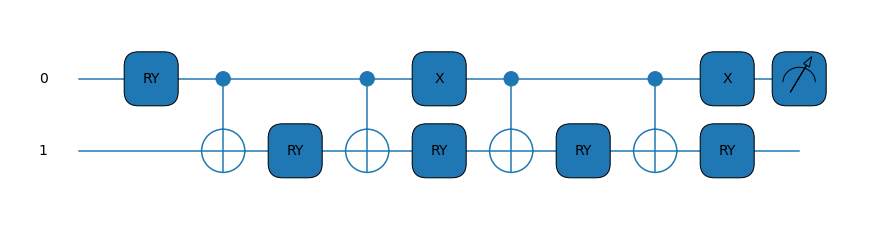

In [20]:
# Dummy data array sent to get_angles function
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

# Defined the Test Quantum node that will run on the Quantum Simulator
# Gets sent the angles, runs the quantum state preparation to angle encode the data and measure expactation value
@qml.qnode(dev)
def test(angles):
    statepreparation(angles)
    return qml.expval(qml.PauliZ(0))
test(ang)

# Print the test data, the angle conversions and Amplitude Vectors after embedding
print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))
print("")
print("")

# Draw Quantum Circuits
qml.draw_mpl(test,expansion_strategy='device', show_all_wires=True)(ang)
print(qml.draw(test,expansion_strategy='device',show_all_wires=True)(ang))

##  Create Circuit Ansatz Layer with Weighting Function
> Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the variational circuit.

> This circuit layer consists of an arbitrary rotation on every qubit, applies the witght, as well as CNOTs that quantum entangles each qubit with its neighbour.

In [21]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

### Test Entire Circuit (StatePrepartion and Ansatz with Dummy Data)

0: ──RY(0.56)─╭●────────────╭●──X────────╭●────────────╭●──X─────────Rot(-0.03,0.01,-0.01)─╭●
1: ───────────╰X──RY(-0.00)─╰X──RY(0.00)─╰X──RY(-0.98)─╰X──RY(0.98)──Rot(-0.01,-0.00,0.01)─╰X

───Rot(-0.00,-0.01,-0.00)─╭●──Rot(-0.00,0.01,0.01)──╭●──Rot(0.01,0.00,0.00)──╭●
───Rot(0.01,-0.02,0.01)───╰X──Rot(-0.02,-0.01,0.01)─╰X──Rot(0.00,0.00,-0.00)─╰X

───Rot(0.02,0.01,0.00)───╭●──Rot(-0.00,-0.00,-0.00)─╭●─┤  <Z>
───Rot(-0.00,-0.00,0.00)─╰X──Rot(-0.00,-0.01,-0.00)─╰X─┤     


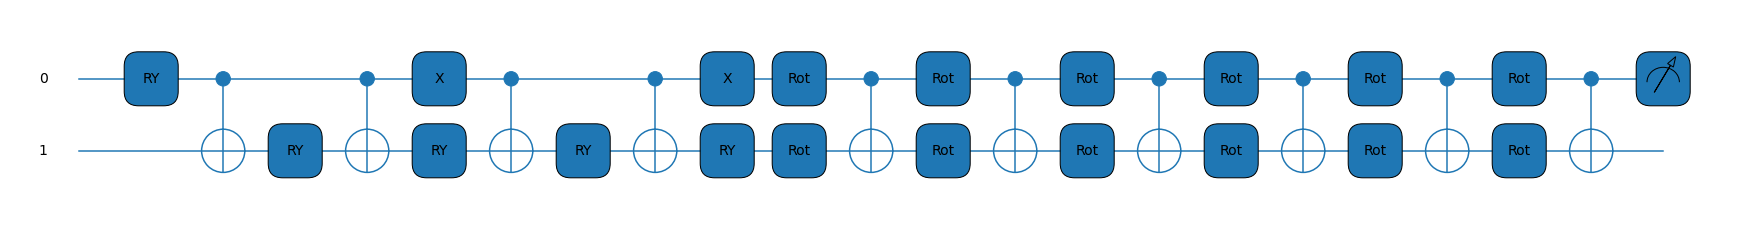

In [22]:
# Run Circuit with Layer Function using Fake data and radom weights to test amd draw circuit

x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
num_layers=6
num_qubits=2
weights = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
ang = get_angles(x)

# Defined the Test Quantum node that will run on the Quantum Simulator
# Gets sent the angles, runs the quantum state preparation to angle encode the data and measure expactation value
@qml.qnode(dev)
def test_Ansatz(weight,angles):
    statepreparation(angles)
    #AngleEmbedding(angles, wires=range(num_qubits))
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))
test_Ansatz(weights,ang)

# Draw Quantum Circuits
qml.draw_mpl(test_Ansatz,expansion_strategy='device', show_all_wires=True)(weights,ang)
print(qml.draw(test_Ansatz,expansion_strategy='device',show_all_wires=True)(weights,ang))

## Redefine the QNODE and Adding the Variational Classfier and Cost Funtions

In [23]:
# Create the QNODE with the circuit, variational classifier and cost
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)
    #AngleEmbedding(angles, wires=range(num_qubits))
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

# Define the variational Classifier function - send weights, bias and angles
# Run them throught the quantum circuit and resturn the circuit resutls (PauliZ) Value + bias
def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

# Define Cost function sending in weights, bias, features and labels
# Fun throught the circuit for every feature and get predictions
# Return the labels and prediction and run them through the square_loss Function
def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

# Define the Square loss function to help define the cost
# The standard square loss measures the distance betwen traget labels and model predictions
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# Define the Accuracy Function to monitor how many inputs were classified correctly.
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

## Manipulate, standardize and normalize the data

In [24]:
# Read 1st two columns of iris dataset (SepalLength,SepalWidth) in array X
X = data[:,0:2]
print("First X sample (original)  :", X[0])

# Pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])
#print(X_pad)

# Normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# Angles for state preparation are the new features that get fed into variational classifier
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])
#print(features)

# Read last colummn of data into array Y
Y = data[:, -1]
print("First Y sample:", Y[0])

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]
First Y sample: -1.0


## Plot the Data SepalLength by SepalWidth
1. Plot the Original Data
2. Plot the Normalized Data
3. PLot the data converted the angles for ange embedding (Features)

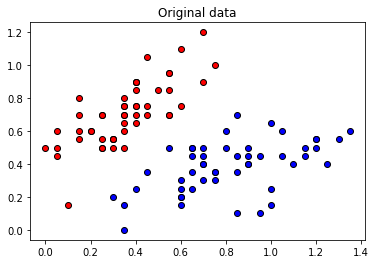

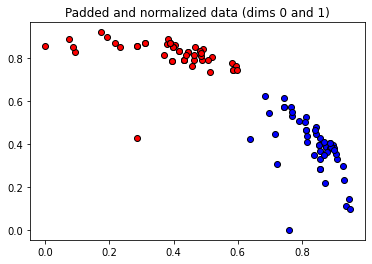

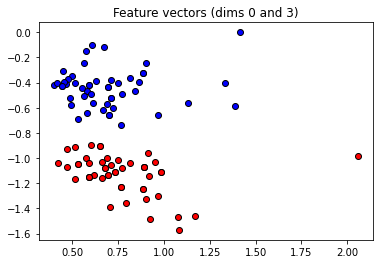

In [25]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalized data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()


## Split Data into Training and Validation

In [26]:
# Generate training and Validation datasets from the original
np.random.seed(0)                                 # Create initial seed
num_data = len(Y)                                 # Get total number of elements in Y array
num_train = int(0.75 * num_data)                  # Get the number of items for 75% of the data
index = np.random.permutation(range(num_data))    # Create random index
feats_train = features[index[:num_train]]         # Create the Features(X) training array - randomly 75%
Y_train = Y[index[:num_train]]                    # Create the Y training array - randomly 75%
feats_val = features[index[num_train:]]           # Create the Feasture(X) validation set
Y_val = Y[index[num_train:]]                      # Create the Y validation set

# These are used later for model results plot
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

## Optimization

In [27]:
# Initialization of the variables with random weights 6 layers deep with 2 qubits (X1,X2)
num_qubits = 2
num_layers = 6     # Modify this to play with different levels of optimizing.

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)


## Optimize the Cost

In [29]:
# Define the Quantum Optimizer being used
# NesterovMomentumOptimizer, AdagradOptimizer, GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer
opt = NesterovMomentumOptimizer(0.01)           # paramter shift rule, gradient descent
batch_size = 5                                  # Number of batches to run at a time

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
         )

Iter:     1 | Cost: 1.5010239 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.5020315 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.4421996 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.3826779 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.2735462 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.1523717 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.0040542 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     8 | Cost: 0.8990333 | Acc train: 0.5733333 | Acc validation: 0.7600000 
Iter:     9 | Cost: 0.8467222 | Acc train: 0.7333333 | Acc validation: 0.7600000 
Iter:    10 | Cost: 0.8375892 | Acc train: 0.7066667 | Acc validation: 0.6800000 
Iter:    11 | Cost: 0.8896866 | Acc train: 0.5866667 | Acc validation: 0.5200000 
Iter:    12 | Cost: 0.9381661 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    13 | Co

## Plot the Training and Validation 
### Prediction Line is determined by optimal variational classifier
#### Plot Using Pythong Matplotlib

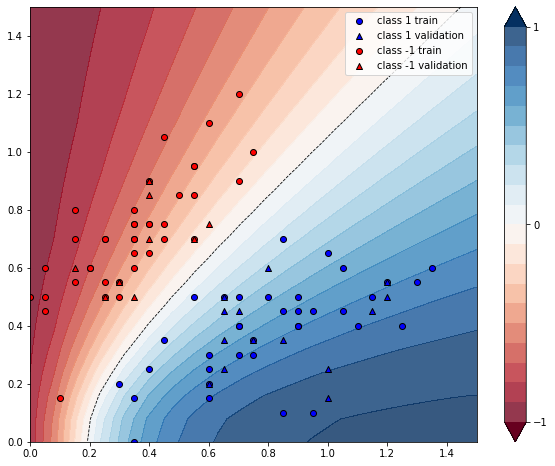

In [30]:
f=plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]


# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

## plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

## Convert Arrays in Dataframes and Then into SAS Datasets

In [32]:
# Convert the dataframes from above into SAS datasets
df_X = pd.DataFrame(xx)
df_Y = pd.DataFrame(yy)
df_Z = pd.DataFrame(Z)
df_xt = pd.DataFrame(X_train)
df_yt = pd.DataFrame(Y_train)
df_xv = pd.DataFrame(X_val)
df_yv = pd.DataFrame(Y_val)
XVARS = sas.df2sd(df_X,'XVARS','work')  
YVARS = sas.df2sd(df_Y, 'YVARS','work')
ZVARS = sas.df2sd(df_Z,'ZVARS','work')
xtrain = sas.df2sd(df_xt,'XTRAIN','work')
xvalid = sas.df2sd(df_xv,'XVALID','work')
ytrain = sas.df2sd(df_yt,'YTRAIN','work')
yvalid = sas.df2sd(df_yv,'YVALID','work')

## Use SAS to Manipulate Resulting Datasets

In [42]:
## Since No Output is Generated the SASLOG is displayed. This can be shutoff using sas.submit() instead of
## sas.submitLST()

code=sas.submitLST("""
%put(SASWORK);

data work.xtrain_1;
    set work.xtrain (rename=('0'n = _XT '1'n = _YT));
    idd=_n_;
run;
data work.xvalid_1;
    set work.xvalid (rename=('0'n = _XV '1'n = _YV));
    idd=_n_;
run;
data work.ytrain_1;
    set work.ytrain (rename=('0'n = YSUBT));
    idd=_n_;
run;
data work.yvalid_1;
    set work.yvalid (rename=('0'n = YSUBV));
    idd=_n_;
run;

data work.data_series;
    merge work.xtrain_1 work.xvalid_1 work.ytrain_1 work.yvalid_1;
    by idd;
run;

""")



## Perform Some More Data Manipulation in SAS and Then Create Graph


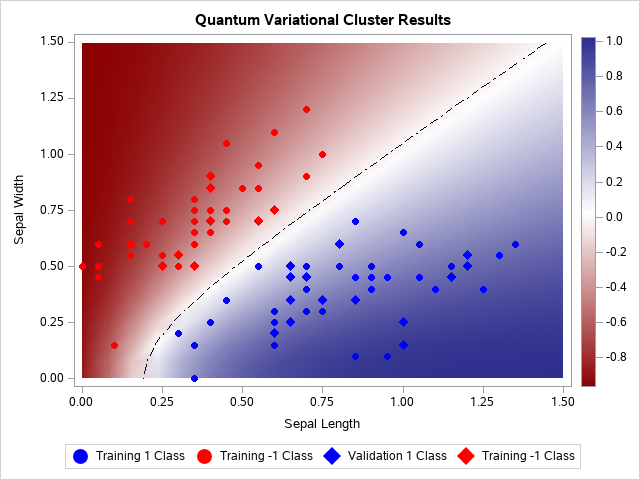

In [44]:

## Create scatterplot of Mutual Information Between Features and DV
code=sas.submitLST("""
title;
%macro mod_data;
%let dnames = XVARS|YVARS|ZVARS;
%do i = 1 %to 3;
    %let dname = %scan(&dnames,&i,'|');

        data work.&dname;
            set work.&dname;
            id=_n_;
        run;
        
        proc transpose data = work.&dname out=work.&dname._t (where=(_name_ ne 'id') rename=(col1=&dname));
            var _numeric_;
            by id;
        run;
        proc sort data = work.&dname._t;
        by id _name_;
        run;
%end;
data work.combined (drop=id _name_);
    merge   work.XVARS_t (in=x /*drop = _name_*/)
            work.YVARS_t (in=y /*drop = _name_*/)
            work.ZVARS_t (in=z /*drop = _name_*/);
    by id _name_;
    if x and y and z;
    idd = _n_;
run;
proc format;
    value t_fmt
        -1 = 'Setosa Training'
        1 = 'Versicolor Training';
    value v_fmt
        -1 = 'Setosa Validation'
        1 = 'Versicolor Validation';
run;

data work.combined_final;
    merge work.combined work.data_series;
    by idd;
run;

/*proc print data = work.combined_final;run;*/
%mend;
%mod_data;
title;
ODS PATH(PREPEND) WORK.TEMPLAT(UPDATE);
proc template;
    define statgraph variationalClassfier;
        begingraph / datacolors=(red blue);
            entrytitle "Quantum Variational Cluster Results";
                discreteattrmap name="train" / ignorecase=true trimleading=true;
                    value "1"    / markerattrs=(color=blue symbol=circlefilled);
                    value "-1"    / markerattrs=(color=red  symbol=circlefilled); 
                enddiscreteattrmap;
                discreteattrmap name="valid" / ignorecase=true trimleading=true;
                    value "1"    / markerattrs=(color=blue symbol=diamondfilled);
                    value "-1"    / markerattrs=(color=red  symbol=diamondfilled); 
                enddiscreteattrmap;
                discreteattrvar attrvar=train var=ysubt attrmap="train";	
                discreteattrvar attrvar=valid var=ysubv attrmap="valid";	
                legenditem type=marker name="train_1" / 
                    markerattrs=(symbol=circlefilled size=12pt color=blue) 
                    label="Training 1 Class";
                legenditem type=marker name="train_-1" / 
                    markerattrs=(symbol=circlefilled size=12pt color=red) 
                    label="Training -1 Class";
                legenditem type=marker name="valid_1" / 
                    markerattrs=(symbol=diamondfilled size=12pt color=blue) 
                    label="Validation 1 Class";
                legenditem type=marker name="valid_-1" / 
                    markerattrs=(symbol=diamondfilled size=12pt color=red) 
                    label="Training -1 Class";
            layout overlay /
                xaxisopts=(label='Sepal Length')
                yaxisopts=(label='Sepal Width');
             
                contourplotparm x=xvars y=yvars z=zvars / contourtype=gradient 
                                                          levels=(-1 -.9 -.8 -.7 -.6 -.5 -.4 -.3 -.2 -.1 0
                                                                  .1 .2 .3 .4 .5 .6 .7 .8 .9 1.0 1.1)
                                                          colormodel=(darkred white darkmoderateblue)
                                                          name="Contour";
                contourplotparm x=xvars y=yvars z=zvars / contourtype=line 
                                                          lineattrs=(pattern=dashdashdot color=black thickness=1px)
                                                          levels=(0.0)
                                                          name="Contour_line";
                scatterplot x=_xt y=_yt / group=train name='Training' legendlabel="Training" includemissinggroup=false;
                scatterplot x=_xv y=_yv / group=valid name='Validation' legendlabel="Validation" includemissinggroup=false;

                continuouslegend "Contour" / valuecounthint=20;
                discretelegend "train_1" "train_-1" "valid_1" "valid_-1" / location=outside autoalign=(bottom);
                endlayout;
        endgraph;
    end;
run;
proc sgrender data = work.combined_final template=variationalClassfier;
run;
           
""")